In [171]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import os

# Authenticate using your Google API credentials
scope = [
    'https://spreadsheets.google.com/feeds',
    'https://www.googleapis.com/auth/spreadsheets',
    'https://www.googleapis.com/auth/drive'
]

credentials = ServiceAccountCredentials.from_json_keyfile_name(
    'C:\\Users\\Moshood\\OneDrive\\dev\\python_data_profiling_scripts\\BODQR\\service_account.json', scopes=scope
)

file = gspread.authorize(credentials)

# Open the Google Sheet
workbook = file.open("bo_data")

# Select the worksheet you want to access   pip 
worksheet = workbook.worksheet("Raw")

# Convert the worksheet data to a data frame
data = pd.DataFrame(worksheet.get_all_values(), columns=worksheet.row_values(1))

data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')

# Adding New columns
data['asset_tag_dup_or_not'] = data.duplicated(subset='Asset Tag', keep=False).map({True: 'Duplicate', False: ''})
data['customerid'] = [data.loc[i, 'Customer Account Number'] if data.loc[i, 'Customer Account Number'] != "" else data.loc[i, 'Customer Meter SLRN (ECG)'] if data.loc[i, 'Customer Meter SLRN (ECG)'] != "" else data.loc[i, 'Customer Account Number'] if data.loc[i, 'Customer Account Number'] != "" and data.loc[i, 'Customer Meter SLRN (ECG)'] != "" else data.loc[i, 'Customer Meter SLRN (ECG)'] for i in range(len(data))]
data['customerid_dup_or_not'] = data.duplicated(subset='customerid', keep=False).map({True: 'Duplicate', False: ''})
data['asset_tag_dup_flag'] = 0
data.loc[(data['Asset Tag'].notnull()) & (data['asset_tag_dup_or_not'] != 'Duplicate'), 'asset_tag_dup_flag'] = 1
data['customerid_dup_flag'] = 0
data.loc[(data['customerid'].notnull()) & (data['customerid_dup_or_not'] != 'Duplicate'), 'customerid_dup_flag'] = 1
def asset_type(asset_tag_dup_flag, asset_type):
    if asset_tag_dup_flag == 1 and asset_type == "Distribution Transformer (DT)":
        return "DT"
    elif (asset_tag_dup_flag == 1 and asset_type == "Building") or (asset_tag_dup_flag == 1 and asset_type == "Building & Customer / Meter"):
        return "Building"
    else:
        return "Duplicate Data"
data['asset_type'] = data.apply(lambda x: asset_type(x['asset_tag_dup_flag'], x['Asset Type']), axis=1)
data['month'] = data['Timestamp'].dt.strftime('%B')
data['year'] = data['Timestamp'].dt.strftime('%Y')
data["week_month"] = data["Timestamp"].dt.strftime("Week %U - %B")
data['day_of_week'] = data['Timestamp'].dt.day_name()
data['month_year'] = data['Timestamp'].dt.strftime('%B - %Y')
data['data_audit_approve'] = np.where((data['Data Audit Review'] == 'Approve') & (data['customerid_dup_or_not'] != 'Duplicate'), 1, 0)
data['data_audit_reject'] = np.where((data['Data Audit Review'] == 'Reject') & (data['customerid_dup_or_not'] != 'Duplicate'), 1, 0)



In [140]:
# calculate the sum of asset_tag_dup_flag
overall_assets_reviewed = data['asset_tag_dup_flag'].sum()
print("Overall Assets Reviewed:", overall_assets_reviewed)

# calculate the sum of customerid_dup_flag
overall_customers_reviewed = data['customerid_dup_flag'].sum()
print("Overall Customers Reviewed:", overall_customers_reviewed)

# calculate the sum of data_audit_approve
total_approved = data['data_audit_approve'].sum()
print("Total Approved:", total_approved)

# calculate the sum of data_audit_reject
total_rejected = data['data_audit_reject'].sum()
print("Total Rejected:", total_rejected)


Overall Assets Reviewed: 17610
Overall Customers Reviewed: 38533
Total Approved: 25489
Total Rejected: 8867


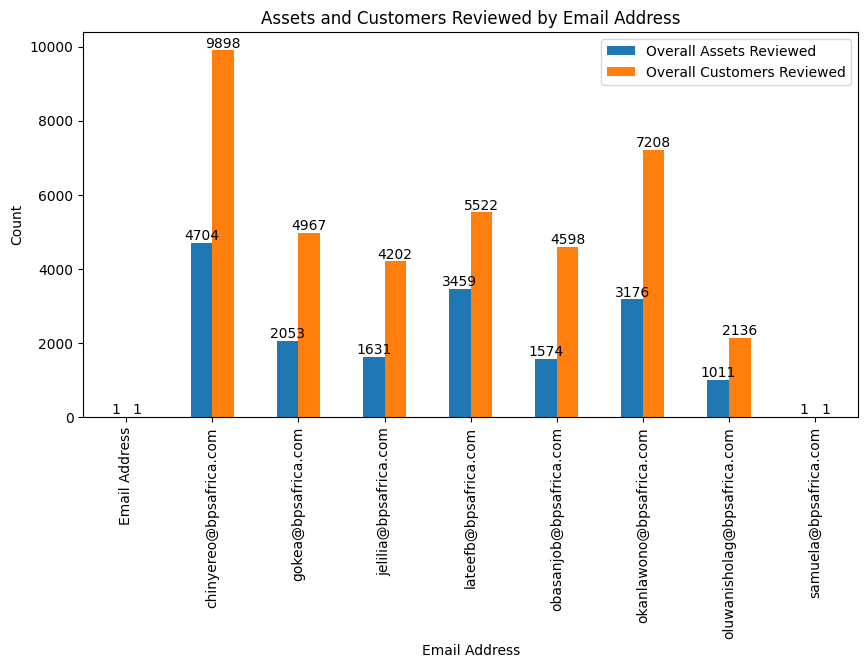

<Figure size 640x480 with 0 Axes>

In [141]:
import matplotlib.pyplot as plt

grouped = data.groupby('Email Address').agg({'asset_tag_dup_flag': 'sum', 'customerid_dup_flag': 'sum'})

fig, ax = plt.subplots()
grouped.plot(kind='bar', ax=ax, figsize=(10, 5))

plt.title("Assets and Customers Reviewed by Email Address")
plt.xlabel("Email Address")
plt.ylabel("Count")

# Adding count values on top of the bars
for i in ax.containers:
    ax.bar_label(i, label_type='edge')

# Rename legend
plt.legend(["Overall Assets Reviewed", "Overall Customers Reviewed"])

plt.show()

# Save the chart as an image file
plt.savefig("assets_customers_reviewed_by_email_address.png")
plt.savefig("C:/Users/Moshood/Downloads/assets_customers_reviewed_by_email_address.png")

In [142]:
grouped = data.groupby(['Site', ]).agg({'asset_tag_dup_flag': 'sum', 'customerid_dup_flag': 'sum'})
print(grouped)

      asset_tag_dup_flag  customerid_dup_flag
Site                                         
AEDC                2907                 3881
ECG                14702                34651
Site                   1                    1


In [178]:
data.shape

(18, 1)

## Finding Missing Dates

In [176]:
import pandas as pd
from datetime import datetime, timedelta, date
import os

bo_data = "C:\\Users\\Moshood\\Downloads\\bo_data_checking gaps_in_date_column.xlsx"
bo_data = pd.read_excel(bo_data)

# Filter the data for a particular site
site = "ECG"
filtered_data = bo_data[bo_data["Site"] == site]

# Adding column 'Site' to the dictionary of lists
d = filtered_data[["Timestamp", "Site"]].copy()
d["Timestamp"] = d["Timestamp"].dt.strftime("%Y-%m-%d")

# Creating dataframe from the above dictionary of lists
dataFrame = pd.DataFrame(d)

# Timestamp set as index
dataFrame = dataFrame.set_index('Timestamp')

# Using to_datetime() to convert string to DateTime object
dataFrame.index = pd.to_datetime(dataFrame.index)

# Missing dates displayed as output
k = pd.date_range(start=dataFrame.index.min(), end=dataFrame.index.max()).difference(dataFrame.index)

# Convert the DatetimeIndex object to a DataFrame
k = pd.DataFrame(k, columns=['Timestamp'])

# ---------------------------------------------------------------------------------------------------------
# Exporting the dataframe to a csv file in a specific directory
directory = r"C:/Users/Moshood/OneDrive/dev/python_data_profiling_scripts/BODQR/exports/docs/"
today = date.today()
now = datetime.now()
if not os.path.exists(directory):
    os.makedirs(directory)

# name of the file
result = k
filename = "export"
filepath = directory + filename

# Save the result to a CSV file
result.to_csv(directory + site + f'_missing_dates_{filename}_{now.strftime("%Y-%m-%d %H-%M-%S")}.csv', index=False)

# ---------------------------------------------------------------------------------------------------------
